In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tqdm import tqdm
import datetime

sns.set_style('darkgrid')
pd.options.display.max_rows = None

In [31]:
transactions = pd.read_csv('../../../data/transactions_train_sample.csv',dtype={"article_id": "str"})
transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])

<AxesSubplot:xlabel='transaction_count', ylabel='Count'>

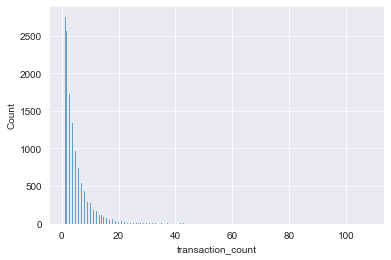

In [32]:
tmp = transactions.groupby('customer_id').article_id.count().reset_index()
tmp.columns = ['customer_id','transaction_count']
sns.histplot(data=tmp,x='transaction_count')

### Map customer_id and article_id to incremental intergers

In [30]:
ALL_USERS = transactions.customer_id.unique().tolist()
ALL_ITEMS = transactions.article_id.unique().tolist()

user_to_customer_map = {u:c for u,c in zip(range(len(ALL_USERS)),ALL_USERS)}
customer_to_user_map = {c:u for u,c in zip(range(len(ALL_USERS)),ALL_USERS)}

item_to_article_map = {i:a for i,a in zip(range(len(ALL_ITEMS)),ALL_ITEMS)}
article_to_item_map = {a:i for i,a in zip(range(len(ALL_ITEMS)),ALL_ITEMS)}

transactions['user_id'] = transactions['customer_id'].map(customer_to_user_map)
transactions['item_id'] = transactions['article_id'].map(article_to_item_map)

In [31]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,user_id,item_id
0,2020-08-22,018df2e9f27d47c0670b9742cbea597e9f06272d2ec8d5...,0868037001,0.067780,2,0,0
1,2020-08-22,01f4206190d208e8c27272a1be22ab728bb134f773ca52...,0730570029,0.018627,2,1,1
2,2020-08-22,01f4206190d208e8c27272a1be22ab728bb134f773ca52...,0919786001,0.042356,2,1,2
3,2020-08-22,01f4206190d208e8c27272a1be22ab728bb134f773ca52...,0874110001,0.025407,2,1,3
4,2020-08-22,02ae5ea6cd4582e66730e9dea1774981717803d5ff2567...,0799365011,0.050831,2,2,4


### Build Model

**Configuration parameters**

Since UUCF is very computationally expensive, we only apply on a small subset of users.

We will reduce data base on a front:
- Keep only the user with at least `MINIMUM_PURCHASES`

In [33]:
N_SIMILAR_USERS = 30

DROP_PURCHASED_ITEMS = True

MINIMUM_PURCHASES = 3

DROP_USER_FROM_HIS_NEIGHBORHOOD = True

In [34]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [35]:
def compare_vectors(v1, v2):
    intersection = len(set(v1) & set(v2))
    denominator = np.sqrt(len(v1) * len(v2))
    return intersection / denominator

In [36]:
def get_similar_users(u, v, dfh):
    similar_users = dfh.apply(lambda v_other: compare_vectors(v, v_other)).sort_values(ascending=False).head(N_SIMILAR_USERS + 1)
    
    if DROP_USER_FROM_HIS_NEIGHBORHOOD:
        similar_users = similar_users[similar_users.index != u]
        
    return similar_users.index.tolist(), similar_users.tolist()

In [37]:
def get_items(u, v, dfh):
    global i, n
    
    users, scores = get_similar_users(u, v, dfh)
    df_nn = pd.DataFrame({'user': users, 'score': scores})
    df_nn['items'] = df_nn.apply(lambda row: dfh.loc[row.user], axis=1)
    df_nn['weighted_items'] = df_nn.apply(lambda row: [(item, row.score) for item in row['items']], axis=1)

    recs = pd.DataFrame(flatten(df_nn['weighted_items'].tolist()), columns=['item', 'score']).groupby('item')['score'].sum().sort_values(ascending=False)
    if DROP_PURCHASED_ITEMS:
        recs = recs[~recs.index.isin(v)]
    # Keep the first 12 and get the item_ids
    i +=1
    if i % 200 == 0:
        pid = mp.current_process().pid
        print(f"[PID {pid:>2d}] Finished {i:3d} / {n:5d} - {i/n*100:3.0f}%")
    return recs.head(6).index.tolist()

In [38]:
def get_items_chunk(user_ids: np.array, dfh: pd.DataFrame):
    global i, n
    i = 0
    
    n = len(user_ids)
    pid = mp.current_process().pid
    print(f"[PID {pid:>2d}] Started working with {n:5d} users")
    
    df_user_vectors = pd.DataFrame(dfh.loc[user_ids]).reset_index()
    df_user_vectors['recs'] = df_user_vectors.apply(lambda row: get_items(row.user_id, row.item_id, dfh), axis=1)
    return df_user_vectors.set_index('user_id')['recs']

In [39]:
def get_recommendations(users: list, dfh: pd.DataFrame):
    time_start = time.time()
    
    # Split into approximately evenly sized chunks
    # We will send just one batch to each CPU 
    user_chunks = np.array_split(users, mp.cpu_count())
    
    f = partial(get_items_chunk, dfh=dfh)
    with Pool(mp.cpu_count()) as p:
        res = p.map(f, user_chunks)
    
    df_rec = pd.DataFrame(pd.concat(res))

    elapsed = (time.time() - time_start) / 60
    print(f"Finished get_recommendations({len(users)}). It took {elapsed:5.2f} mins")
    return df_rec

In [40]:
def uucf(df):
    print(f"Total rows: {len(df)}")
    
    # H stands for "Transaction history"
    # dfh is a series of user_id => list of item_id (the list of purchases in order)
    dfh = df.groupby("user_id")['item_id'].apply(lambda items: list(set(items)))
    dfh = dfh[dfh.str.len() >= MINIMUM_PURCHASES]

    users = dfh.index.tolist()
    n_users = len(users)
    print(f"Total users in the time frame with at least {MINIMUM_PURCHASES}: {n_users}")
    
    df_rec = get_recommendations(users, dfh)
    df_rec['customer_id'] = df_rec.index.map(user_to_customer_map)
    df_rec['prediction'] = df_rec['recs'].map(lambda l: [item_to_article_map[i] for i in l])
    
    # Submission ready dataframe
    df_rec.reset_index(drop=True)[['customer_id', 'prediction']]
    return df_rec 

### Prediction


In [41]:
import time
import multiprocessing as mp
from multiprocessing import Pool
from functools import partial

In [42]:
df_recs = uucf(transactions)

Total rows: 59288
Total users in the time frame with at least 3: 7032
[PID 214] Started working with  3516 users
[PID 215] Started working with  3516 users
[PID 215] Finished 200 /  3516 -   6%
[PID 214] Finished 200 /  3516 -   6%
[PID 215] Finished 400 /  3516 -  11%
[PID 214] Finished 400 /  3516 -  11%
[PID 215] Finished 600 /  3516 -  17%
[PID 214] Finished 600 /  3516 -  17%
[PID 215] Finished 800 /  3516 -  23%
[PID 214] Finished 800 /  3516 -  23%
[PID 215] Finished 1000 /  3516 -  28%
[PID 214] Finished 1000 /  3516 -  28%
[PID 215] Finished 1200 /  3516 -  34%
[PID 214] Finished 1200 /  3516 -  34%
[PID 215] Finished 1400 /  3516 -  40%
[PID 214] Finished 1400 /  3516 -  40%
[PID 215] Finished 1600 /  3516 -  46%
[PID 214] Finished 1600 /  3516 -  46%
[PID 215] Finished 1800 /  3516 -  51%
[PID 214] Finished 1800 /  3516 -  51%
[PID 215] Finished 2000 /  3516 -  57%
[PID 214] Finished 2000 /  3516 -  57%
[PID 215] Finished 2200 /  3516 -  63%
[PID 214] Finished 2200 /  3516 -

In [43]:
df_recs.head()

,recs,customer_id,prediction
user_id,,,
0,"[7858, 1681, 4215, 0, 9823, 2050]",018df2e9f27d47c0670b9742cbea597e9f06272d2ec8d5...,"[0894780001, 0570189002, 0908081003, 086803700..."
1,"[3, 356, 1563, 2621, 7832, 1635]",01f4206190d208e8c27272a1be22ab728bb134f773ca52...,"[0874110001, 0714790024, 0448509001, 080375701..."
2,"[19, 12, 17, 302, 554, 555]",02ae5ea6cd4582e66730e9dea1774981717803d5ff2567...,"[0914441001, 0914441005, 0914441004, 087489100..."
4,"[21, 1642, 5034, 5035, 206, 3133]",03a3ea598ac18b8cd9efe64998af2aa7306b412ef5217a...,"[0898694001, 0928088001, 0894135001, 086579900..."
5,"[28, 29, 27, 2786, 3702, 1004]",056729b03521f2526ca9a436f0ef8074ea870e6cc6de43...,"[0399061008, 0852374013, 0716672003, 089768400..."


In [44]:
df_recs = df_recs.drop(['recs'], axis=1)

In [45]:
df_recs.prediction = df_recs.prediction.apply(lambda x: ' '.join(x))

In [46]:
df_recs.head()

,customer_id,prediction
user_id,,
0,018df2e9f27d47c0670b9742cbea597e9f06272d2ec8d5...,0894780001 0570189002 0908081003 0868037001 09...
1,01f4206190d208e8c27272a1be22ab728bb134f773ca52...,0874110001 0714790024 0448509001 0803757015 08...
2,02ae5ea6cd4582e66730e9dea1774981717803d5ff2567...,0914441001 0914441005 0914441004 0874891003 08...
4,03a3ea598ac18b8cd9efe64998af2aa7306b412ef5217a...,0898694001 0928088001 0894135001 0865799005 08...
5,056729b03521f2526ca9a436f0ef8074ea870e6cc6de43...,0399061008 0852374013 0716672003 0897684002 08...


In [47]:
df_recs.to_csv('uucf.csv',index=False)

### Visulize Prediction

In [33]:
import math
import random

In [34]:
df_recs = pd.read_csv('uucf.csv')

cus_id: ca3be0fdad709312ff004398f3a50b1023c2e06bf0bae7244e1c2ae91be2640a
pred: ['0868823008', '0907527001', '0918292004', '0791587001', '0856270002', '0832482001']
last_purchase: ['0916926006', '0865250001', '0918292001']
Prediction


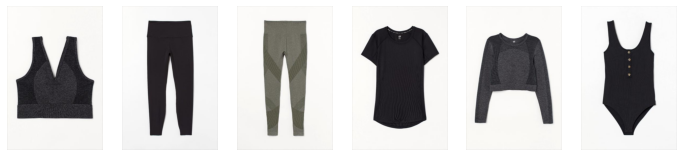

Last Purchase


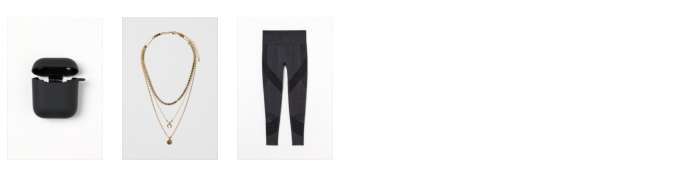

In [38]:
index = random.randint(0,df_recs.shape[0]-1)

cus_id = df_recs.loc[index,'customer_id']
pred = df_recs.loc[index,'prediction'].split(' ')
last_purchase = list(transactions.loc[
    transactions.customer_id == cus_id,
    'article_id'].unique())

print('cus_id:',cus_id)
print('pred:', pred)
print('last_purchase:', last_purchase)

print('Prediction')
fig,axes = plt.subplots(nrows=1,ncols=6,figsize=(12,3))
axes = axes.flatten()
for im_id,ax in zip(pred,axes):
    ax.axis('off')
    im = plt.imread(f'../../../data/images/{im_id[:3]}/{im_id}.jpg')
    ax.imshow(im)
plt.show()

print('Last Purchase')
nr = math.ceil(len(last_purchase)/6)
fig,axes = plt.subplots(nrows=nr,ncols=6,figsize=(12,nr*3))
axes = axes.flatten()
last_purchase += [None]*(nr*6-len(last_purchase))
for im_id,ax in zip(last_purchase,axes):
    ax.axis('off')
    if im_id is not None:
        im = plt.imread(f'../../../data/images/{im_id[:3]}/{im_id}.jpg')
        ax.imshow(im)
plt.show()